In [2]:
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from VAE import ConvVAE, get_model_size

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]

In [5]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [6]:
from torch.utils.data import random_split
from torchvision import transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)),
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2))  # Pad to 32x32
])
# Assuming mnist_data and mnist_label are already defined
dataset = MNISTDataset(mnist_data, mnist_label, transform=transform)

# Define the lengths for training and validation sets
train_size = 50000
val_size = 10000
# train_size = 500
# val_size = 100
test_size = len(dataset) - train_size - val_size
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Now you can use train_dataset and val_dataset with DataLoader



In [8]:
EPOCHS = 100
batch_size = 64
num_workers = 8
T = 1000
lr = 1e-3
latent_dim = 16
lamda = 0.1

model = ConvVAE(latent_dim).to(device)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/mnt/d/data/mnist_model/vae_epoch_100.pth"
model.load_state_dict(torch.load( f"/mnt/d/data/mnist_model/vae_lr_{lr}_epoch_{EPOCHS}_latent{latent_dim}_lambda_{lamda}.pth", map_location=device))


/tmp/ipykernel_380130/3490078493.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( f"/mnt/d/data/mnist_model/vae_lr_{lr}_epoch_{EPOCHS}_l

<All keys matched successfully>

In [10]:
from matplotlib import pyplot as plt
import torchvision.utils as vutils
def show_images(images):
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
    plt.axis('off')
    plt.show()
    plt.close()

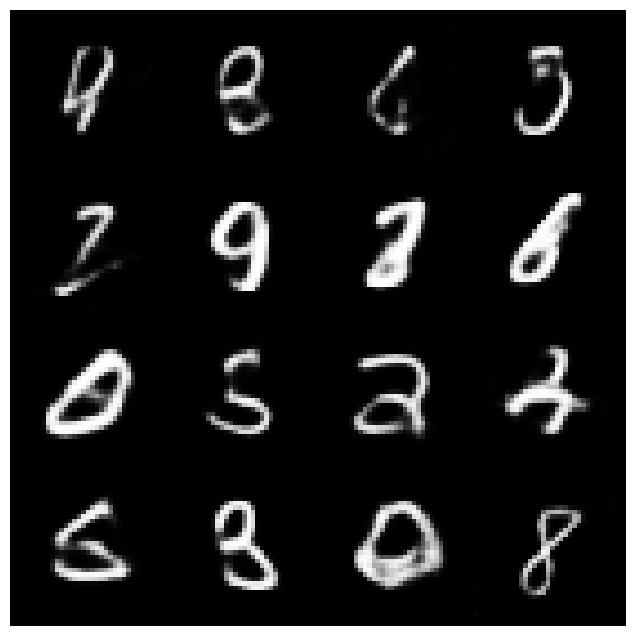

In [11]:
test_data = torch.randn(16, 1, latent_dim).to(device)  # 修改第一维度为16

with torch.no_grad():
    model.eval()
    output = model.decode(test_data)
    show_images(output)
    

In [15]:
result = torch.empty(10000, 1, 32, 32)
with torch.no_grad():
    model.eval()
    # Generate 100 batches of 100 images each
    for i in range(100):
        print(f"Generating batch {i+1}/100")
        test_data = torch.randn(100, 1, latent_dim).to(device)  # 修改第一维度为16
        output = model.decode(test_data)
        result[i*100:(i+1)*100] = output
    

Generating batch 1/100
Generating batch 2/100
Generating batch 3/100
Generating batch 4/100
Generating batch 5/100
Generating batch 6/100
Generating batch 7/100
Generating batch 8/100
Generating batch 9/100
Generating batch 10/100
Generating batch 11/100
Generating batch 12/100
Generating batch 13/100
Generating batch 14/100
Generating batch 15/100
Generating batch 16/100
Generating batch 17/100
Generating batch 18/100
Generating batch 19/100
Generating batch 20/100
Generating batch 21/100
Generating batch 22/100
Generating batch 23/100
Generating batch 24/100
Generating batch 25/100
Generating batch 26/100
Generating batch 27/100
Generating batch 28/100
Generating batch 29/100
Generating batch 30/100
Generating batch 31/100
Generating batch 32/100
Generating batch 33/100
Generating batch 34/100
Generating batch 35/100
Generating batch 36/100
Generating batch 37/100
Generating batch 38/100
Generating batch 39/100
Generating batch 40/100
Generating batch 41/100
Generating batch 42/100
G

In [16]:
import tifffile as tif
import os
result_dir = "/mnt/d/data/mnist_result/vae_result/"
os.makedirs(result_dir, exist_ok=True)
from os.path import join as ospj
for i in range(result.shape[0]):
    tif.imwrite(ospj(result_dir, f"{str(i).zfill(5)}.tif"), result[i][0, 2:-2, 2:-2].squeeze().cpu().numpy())
    

In [17]:
test_dir = "/mnt/d/data/mnist_result/test_sample/"
result_dir = "/mnt/d/data/mnist_result/vae_result/"
import torchvision.transforms as transforms

real_images_folder = test_dir
# generated_images_folder = './FID_app3'
generated_images_folder = result_dir
import torch
import torchvision
from pytorch_fid import fid_score

inception_model = torchvision.models.inception_v3(pretrained=True)

fid_value = fid_score.calculate_fid_given_paths([real_images_folder, generated_images_folder],
                                                batch_size=50,
                                                device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                                                dims=2048                                                 
                                                )
print("FID score:", fid_value)


/home/debugwang/anaconda3/envs/py312/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/debugwang/anaconda3/envs/py312/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


FID score: 2.8625285101150486


/home/debugwang/anaconda3/envs/py312/lib/python3.10/site-packages/scipy/linalg/_matfuncs_sqrtm.py:200: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
